In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb
from itertools import combinations

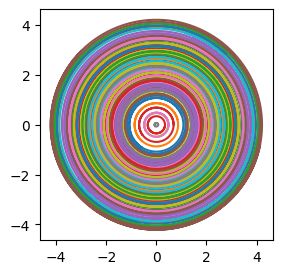

In [2]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - 1*x2 
    dx2_dt = 1*x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 400)     # time points where the solution is computed


num_trajectories = 150

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')



In [4]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)                                                                        #(K, N, T)

compute_S(X) #np.mean(compute_S(X, iterations=100))

Array(1.0284693, dtype=float32)

0.3498329


[Array(0.34593505, dtype=float32),
 Array(0.34684828, dtype=float32),
 Array(0.34775043, dtype=float32),
 Array(0.34881842, dtype=float32),
 Array(0.35088187, dtype=float32),
 Array(0.34525573, dtype=float32),
 Array(0.3478576, dtype=float32),
 Array(0.35929167, dtype=float32),
 Array(0.35058638, dtype=float32),
 Array(0.35158125, dtype=float32),
 Array(0.35307434, dtype=float32),
 Array(0.347085, dtype=float32),
 Array(0.3463695, dtype=float32),
 Array(0.34980452, dtype=float32),
 Array(0.3528764, dtype=float32),
 Array(0.34750485, dtype=float32),
 Array(0.34480357, dtype=float32),
 Array(0.34812215, dtype=float32),
 Array(0.34918436, dtype=float32),
 Array(0.34884652, dtype=float32),
 Array(0.3478866, dtype=float32),
 Array(0.3480915, dtype=float32),
 Array(0.34364507, dtype=float32),
 Array(0.34871373, dtype=float32),
 Array(0.34908897, dtype=float32),
 Array(0.3528493, dtype=float32),
 Array(0.34848326, dtype=float32),
 Array(0.35000134, dtype=float32),
 Array(0.34735098, dtype=flo

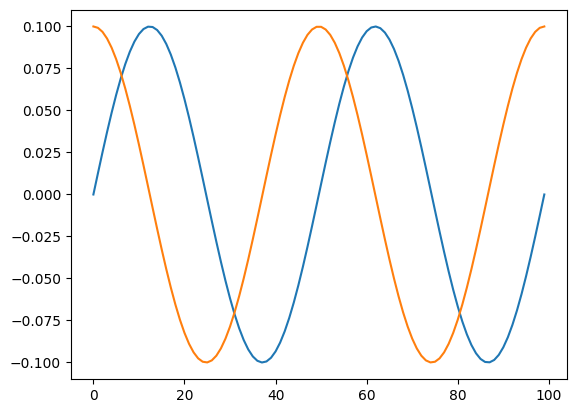

In [3]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )

num_trajectories = 20 
time_steps = 100

time = jnp.linspace(0, 4 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)
X = time + phases 
sine_waves = jnp.sin(X) * radii
cosine_waves = jnp.cos(X) * radii
X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

print(np.mean(compute_S(X, iterations=100)))
plt.plot(sine_waves[:,0])
plt.plot(cosine_waves[:,0])
compute_S(X)

In [4]:
all_combinations = np.array(list(combinations(range(10), 2)))
num_pairs = 10 
key = random.PRNGKey(seed)
indices = random.randint(key, shape=(num_pairs *2,), minval=0, maxval=all_combinations.shape[0])
index_pairs = indices.reshape((num_pairs, 2))

In [26]:
key = random.PRNGKey(42)
all_combinations = np.array(list(combinations(range(10), 2)))
num_pairs = 10
indices = random.randint(key, shape=(num_pairs,), minval=0, maxval=all_combinations.shape[0])
all_combinations[indices]

array([[1, 8],
       [5, 8],
       [2, 4],
       [5, 8],
       [0, 6],
       [6, 8],
       [1, 7],
       [6, 9],
       [2, 8],
       [1, 7]])

In [27]:
all_combinations.shape[0]

45

In [40]:

# def single_pair_S(X, id_1, id_2, operator):
#     XX = jnp.einsum('ij,kj->ik', X[id_1, :, :], X[id_2, :, :])          #(N,N)
#     #XX_product = jnp.einsum('ij,lm->im', XX, XX)                        #(N,N)
#     XX_product = XX @ XX

#     if operator == 'minus':
#         return jnp.trace(XX)**2 - jnp.trace(XX_product)
    
#     elif operator == 'plus':
#         return jnp.trace(XX)**2 + jnp.trace(XX_product)


# def compute_S(X, seed=42, iterations=1, num_pairs = 100, ratio=True):
#     index_pairs = np.array(list(combinations(range(20), 2)))

#     batched_numerator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'minus')
#     batched_denominator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'plus') 

#     return jnp.sum(batched_numerator) / jnp.sum(batched_denominator) 


def single_pair_S(X, id_1, id_2, operator):
    XX = jnp.einsum('ij,kj->ik', X[id_1, :, :], X[id_2, :, :])          #(N,N)
    #XX_product = jnp.einsum('ij,lm->im', XX, XX)                        #(N,N)
    XX_product = XX @ XX

    if operator == 'minus':
        return jnp.trace(XX)**2 - jnp.trace(XX_product)
    
    elif operator == 'plus':
        return jnp.trace(XX)**2 + jnp.trace(XX_product)


def compute_S(X, seed=42, iterations=1000, num_pairs = 100, ratio=True):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    keys = random.split(key, num=iterations)

    S_list = []
    for i in range(iterations):
        num_pairs = 100
        indices = random.randint(keys[i], shape=(num_pairs*2,), minval=0, maxval=K)
        index_pairs = indices.reshape((num_pairs, 2))
        # all_combinations = jnp.array(list(combinations(range(K), 2)))
        # indices = random.randint(keys[i], shape=(num_pairs,), minval=0, maxval=all_combinations.shape[0])
        # index_pairs = all_combinations[indices]

        batched_numerator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'minus')
        if ratio:
            batched_denominator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'plus') 
            S_list.append( jnp.sum(batched_numerator) / jnp.sum(batched_denominator) )
        else: 
            S_list.append( (2 / (num_pairs**2) ) * jnp.sum(batched_numerator) )

    return S_list

np.mean(compute_S(X))

0.9638133

In [4]:
def projected_X_linear(X, seed = 42, proj_dims = 10, plot=False):
    key = random.PRNGKey(seed)
    key, subkey = random.split(key)

    #Project X
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    
    #Observation noise 
    noise = random.normal(subkey, (X.shape)) 
    X += (noise)  /100
    X = jnp.array(X)

    if plot:
        plt.figure(figsize=(3,3))
        for i,initial_conditions in enumerate(initial_conditions_list):
            plt.plot(X[i,0,:],X[i,10,:] )
    return X
 

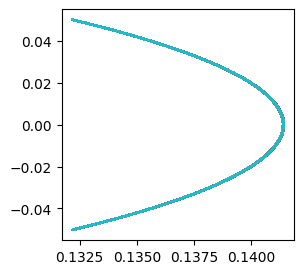

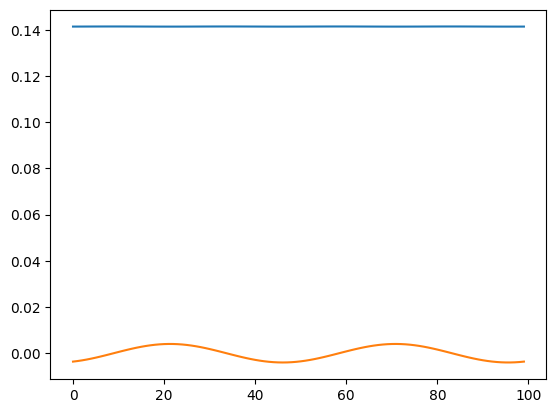

In [10]:

## 

D = 50 #=N'
l = 5
mean = jnp.array([0.0, 0.0])  
covariance = jnp.array([[(1/l**2), 0.0], [0.0, (1/l**2)]])

key = random.PRNGKey(seed)
key, subkey = random.split(key)
num_samples = D
samples_omega = random.multivariate_normal(key, mean, covariance, shape=(num_samples,)) #(N',N) 

dot_prod = jnp.einsum('lj,ijk->ilk', samples_omega, X)                                  #(K, N', T)
K, _, T = dot_prod.shape

cos_values = jnp.cos(dot_prod)
sin_values = jnp.sin(dot_prod)

phi = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(D))                           #(K, 2*N', T)
# phi = jnp.stack((cos_values, sin_values), axis=-2)
# new_shape = (K, 2*D, T)
# phi = phi.reshape(new_shape) * (1 / jnp.sqrt(D))                                        #(K, 2*N', T)

# noise = random.normal(subkey, (phi.shape)) 
# phi += (noise)  /1000
# phi = jnp.array(phi)

plt.figure(figsize=(3,3))
for i,initial_conditions in enumerate(initial_conditions_list):
    plt.plot(phi[i,2,:], phi[i,52,:] )

# for i in range(5):
plt.figure()
plt.plot(phi[0,0,:] )
plt.plot(phi[0,50,:] )

(20, 100, 100)
(2000, 100)


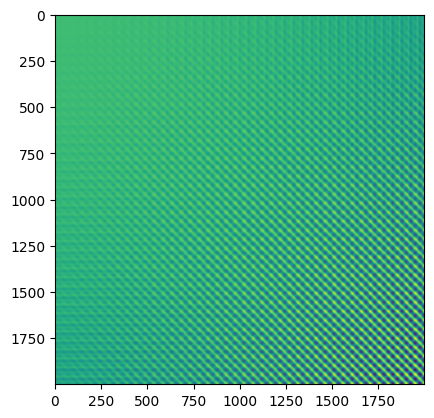

In [12]:
cov = np.cov( np.concatenate(phi.swapaxes(1,2)) )
print(phi.shape)
print(np.concatenate(phi.swapaxes(1,2)).shape)
plt.imshow(np.cov( np.concatenate(phi.swapaxes(1,2)) ))

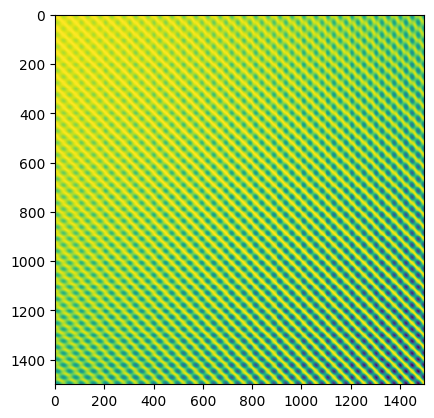

In [11]:
def K_X_Y_squared_exponential(X, Y, l=1.0, sigma_f=1.0):
    sq_dist = jnp.sum((X.T[:, jnp.newaxis, :] - Y.T[jnp.newaxis, :, :])**2, axis=2)
    return sigma_f**2 * jnp.exp(-0.5 / l**2 * sq_dist)

split = 5
X_train = phi[split:]
X_test = phi[:split]
K, N, T = X_train.shape

A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)

# K_A_X = K_X_Y_identity(A, X_train)               #(K*T, K, T)
# K_A_A = K_X_Y_identity(A, A)

K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X_train[k], l = l)
K_A_X = jnp.array(K_A_X)

K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

plt.imshow(K_A_A)

In [12]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X_train, d=d, learning_rate=0.01, iterations=1000) 
wandb.finish

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 2.9416027391704347e-09, S_ratio: 0.1026260256767273
Iteration 10, S: 3.302364159907256e-09, S_ratio: 0.10504177957773209
Iteration 20, S: 4.221273108839796e-09, S_ratio: 0.1098858192563057
Iteration 30, S: 3.8563650051059994e-09, S_ratio: 0.1434234380722046
Iteration 40, S: 5.4696833728939964e-09, S_ratio: 0.15924105048179626
Iteration 50, S: 6.7677143889000035e-09, S_ratio: 0.15315492451190948
Iteration 60, S: 7.97526578111274e-09, S_ratio: 0.17195239663124084
Iteration 70, S: 9.783504673066545e-09, S_ratio: 0.1864420771598816
Iteration 80, S: 1.313891928589328e-08, S_ratio: 0.20264336466789246
Iteration 90, S: 1.5053172930379333e-08, S_ratio: 0.2404569387435913
Iteration 100, S: 2.6133252006843577e-08, S_ratio: 0.22903501987457275
Iteration 110, S: 2.813179378335917e-08, S_ratio: 0.24875132739543915
Iteration 120, S: 3.7279868081441236e-08, S_ratio: 0.26022082567214966
Iteration 130, S: 4.6392393926453224e-08, S_ratio: 0.2633973956108093
Iteration 140, S: 7.2966180653

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

In [13]:
np.save('alpha_tilde', alpha_tilde)

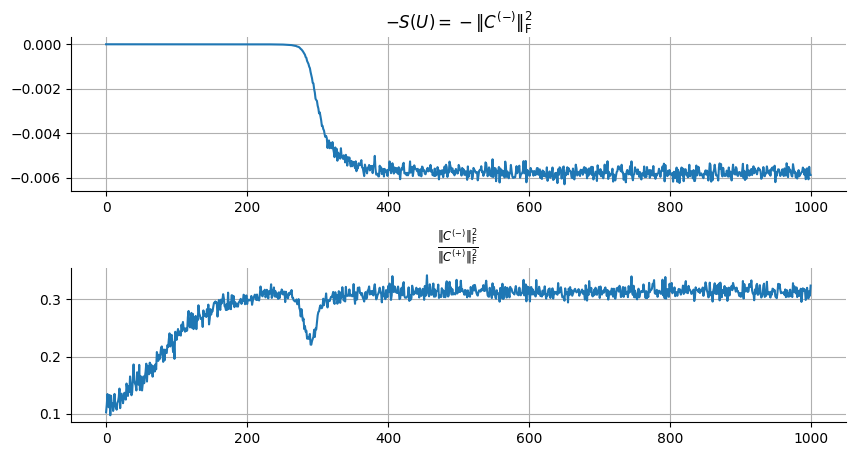

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Array(0.2978087, dtype=float32)

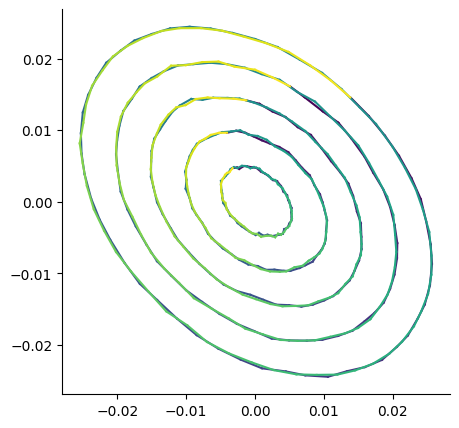

In [17]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

K_test, _, _ = X_test.shape
K_A_X_test = np.zeros((K*T, K_test, T))
for k in range(K_test):
    K_A_X_test[:,k,:] = K_X_Y_squared_exponential(A, X_test[k], l = l)
K_A_X_test = jnp.array(K_A_X_test)

#K_A_X_test = K_X_Y_identity(A, X_test)                                     #(K*T, K, T)

projection = jnp.einsum('ij,imk->mjk', alpha_H, K_A_X_test[:,:,:])                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection)


In [19]:
def single_pair_S(X, id_1, id_2, operator):
    XX = jnp.einsum('ij,kj->ik', X[id_1, :, :], X[id_2, :, :])          #(N,N)
    #XX_product = jnp.einsum('ij,lm->im', XX, XX)                       #(N,N)
    XX_product = XX @ XX

    if operator == 'minus':
        return jnp.trace(XX)**2 - jnp.trace(XX_product)
    
    elif operator == 'plus':
        return jnp.trace(XX)**2 + jnp.trace(XX_product)


def compute_S(X, seed=42, iterations=1, num_pairs = 100, ratio=True):
    index_pairs = np.array(list(combinations(range(20), 2)))

    batched_numerator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'minus')
    batched_denominator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'plus') 

    return jnp.sum(batched_numerator) / jnp.sum(batched_denominator) 

compute_S(projection)

Array(0.2978087, dtype=float32)

Text(0.5, 1.0, 'pca 1.00')

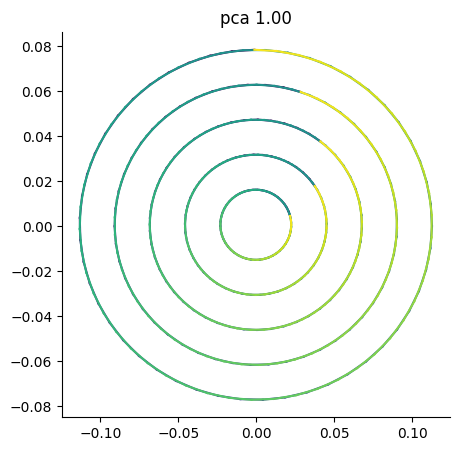

In [23]:
""" PCA """
X_train_pca = np.concatenate(X_train.swapaxes(1,2))
X_test_pca = np.concatenate(X_test.swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_train_pca).transform(X_test_pca)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, time_steps, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plt.title(f"pca {var_explained(X_test, PCs[:2].T):.2f}")




ENDS HERE

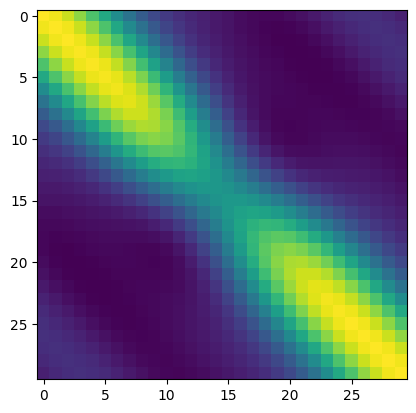

In [40]:
def sample_rff(
    x,
    kernel,
    lengthscale,
    coefficient,
    num_functions,
    num_features,
):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale
    omega = omega / lengthscale
    
    weights = np.random.normal(
        loc=0.,
        scale=1.,
        size=(num_functions, num_features),
    )
    
    phi = np.random.uniform(
        low=0.,
        high=(2 * np.pi),
        size=(num_functions, num_features, 1),
    )
    
    #features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    #features = (2 / num_features) ** 0.5 * features * coefficient

    features = np.einsum('sfd, nd -> sfn', omega, x)
    cos_values = jnp.cos(features)
    sin_values = jnp.sin(features)
    features = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(num_features)) 
    
    #functions = np.einsum('sf, sfn -> sn', weights, features)
    functions=None
    
    return functions, features

lengthscale = 1.
coefficient = 1.
num_functions = 10
num_features = 50

# Input locations
x = np.linspace(-3., 3., 30)[:, None]

functions, features = sample_rff(x=x,       #features (K, N, T)
        kernel='eq', 
        lengthscale=lengthscale, 
        coefficient=coefficient, 
        num_functions=num_functions, 
        num_features=num_features,
    )

plt.imshow(np.cov(features[1].T))